# Artificial neural network

In [69]:
from __future__ import division
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from math import sqrt
import time
import csv
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
from pandas import Series, DataFrame, Panel

## Configurations

In [88]:
# Location of datasets
directory_path = "~/code/datamining/proj3/datasets"

# Partition % of datasets
training_data_percentage = 70
validation_data_percentage = 15
test_data_percentage = 15

# The various values of lambda and num of hidden units we will try
lambda_val_list = np.arange(0.05, 1.05, 0.05)
n_hidden_list = range(1,80,1)

# Max number of iterations for minimization
opts = {'maxiter' : 50}

file1 = directory_path + "/project3_dataset1.txt"
file2 = directory_path + "/project3_dataset2.txt"

train_data_file3 = directory_path + "/dataset3" + "/train.txt"
train_label_file3 = directory_path + "/dataset3" + "/train_truth.txt"
test_data_file3 = directory_path + "/dataset3" + "/test.txt"

In [71]:
def applyPCA(X):
    pca = PCA(n_components=2)
    X_transformed = pca.fit_transform(X)
    return X_transformed

def generateLabelVector(x):
    vector = np.repeat(np.array([0]), 10, 0)
    vector[x] = 1
    return vector

def doFeatureSelection(train_data, validation_data, test_data):

    n_rows = train_data.shape[0]
    n_cols = train_data.shape[1]
    is_first_run = True
    
    new_train_data = train_data
    new_validation_data = validation_data
    new_test_data = test_data
    
    if train_data.shape[0]!=0:
        for i in range(n_cols):
            
            col_flag = False
            temp = train_data[0][i]
            
            for j in range(1, n_rows):
                if train_data[j][i] != temp:
                    col_flag = True
                    break
            if col_flag is True:
                if is_first_run is True:
                    new_train_data = np.array([train_data[:, i]]) # create matrix 
                    new_train_data = np.reshape(new_train_data, (n_rows, -1))
                    
                    new_validation_data = np.array([validation_data[:, i]]) # create matrix 
                    new_validation_data = np.reshape(new_validation_data, (validation_data.shape[0], -1))
                    
                    new_test_data = np.array([test_data[:, i]]) # create matrix 
                    new_test_data = np.reshape(new_test_data, (test_data.shape[0], -1))
                    
                    is_first_run = False;
                else:
                    tempmatrix = np.reshape(np.array([train_data[:, i].T]), (train_data.shape[0],-1))
                    new_train_data = np.append(new_train_data, tempmatrix, 1)
                    
                    tempmatrix = np.reshape(np.array([validation_data[:, i].T]), (validation_data.shape[0],-1))
                    new_validation_data = np.append(new_validation_data, tempmatrix, 1)
                    
                    tempmatrix = np.reshape(np.array([test_data[:, i].T]), (test_data.shape[0],-1))
                    new_test_data = np.append(new_test_data, tempmatrix, 1)
        
    return new_train_data, new_validation_data, new_test_data

# Pre-processing data

In [72]:
def categorical_to_numeric(dataframe):
    for i in range(len(dataframe.columns)):
        val = dataframe[i].values[0]
        if (isinstance(val, str) and not val.isdigit()):
            column = dataframe[i].values
            unique_values = np.unique(column)
            mapper = {value: index for (index, value) in enumerate(unique_values)}

            dataframe.replace({i: mapper}, inplace=True)
    return dataframe

def get_data_partitions(filepath):
    # Make dataframe
    df = pd.read_csv(filepath, delimiter="\t", header=None)

    # Identify the categorical data columns and convert them to a numerical representation
    df = categorical_to_numeric(df)

    # Calculate sizes of partitions
    size_of_dataset = df.shape[0]
    train_size = int(training_data_percentage * size_of_dataset / 100.0)
    validation_size = int(validation_data_percentage * size_of_dataset / 100.0)
    test_size = int(test_data_percentage * size_of_dataset / 100.0)

    # Shuffle the rows
    df = df.iloc[np.random.permutation(len(df))]
    df = df.reset_index(drop=True)

    # Make partitions
    training_partition = df[:train_size].as_matrix()
    validation_partition = df[train_size:train_size+validation_size].as_matrix()
    test_partition = df[train_size+test_size:test_size+train_size+validation_size].as_matrix()

    return training_partition, validation_partition, test_partition

def get_labels(label_column):
    zeros = [(1 if x==0 else 0) for x in label_column]
    ones = [(0 if x==0 else 1) for x in label_column]
    labels = np.column_stack((zeros, ones))
    return labels

def get_data(filepath):
    training_partition, validation_partition, test_partition = get_data_partitions(filepath)

    # Make label data
    training_labels = get_labels(training_partition[:, -1])
    validation_labels = get_labels(validation_partition[:, -1])
    test_labels = get_labels(test_partition[:, -1])

    # Data (without the label column)
    train_data = training_partition[:,:-1]
    validation_data = validation_partition[:,:-1]
    test_data = test_partition[:,:-1]

     
    # Perform feature-selection
    train_data, validation_data, test_data = doFeatureSelection(train_data, validation_data, test_data)
#     train_data = applyPCA(train_data)
#     validation_data = applyPCA(validation_data)
#     test_data = applyPCA(test_data)
    
    return train_data, training_labels, validation_data, validation_labels, test_data, test_labels

In [106]:
# Plot functions

def plot_dataframe_results(df, legend_location = 'upper center', has_test_labels=True):    
    figure = plt.figure()
    figure.set_size_inches(15.5, 5.5)
    
    plt.subplot(1, 2, 1)
    plt.plot(df['n_hidden'][:len(n_hidden_list)].values, df['train_acc'][:len(n_hidden_list)].values, label='Training set accuracy')
    plt.plot(df['n_hidden'][:len(n_hidden_list)].values, df['validation_acc'][:len(n_hidden_list)].values, label='Validation set accuracy')
    if has_test_labels:
        plt.plot(df['n_hidden'][:len(n_hidden_list)].values, df['test_acc'][:len(n_hidden_list)].values, label='Test set accuracy')
    plt.xlabel('# of hidden units')
    plt.xticks(n_hidden_list[4::5])
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend(loc=legend_location, bbox_to_anchor=(0.5, -0.15), ncol=1, fancybox=True, shadow=True)
    
    plt.subplot(1, 2, 2)
    plt.plot(df['lambda'][len(n_hidden_list):].values, df['train_acc'][len(n_hidden_list):].values, label='Training set accuracy')
    plt.plot(df['lambda'][len(n_hidden_list):].values, df['validation_acc'][len(n_hidden_list):].values, label='Validation set accuracy')
    if has_test_labels:
        plt.plot(df['lambda'][len(n_hidden_list):].values, df['test_acc'][len(n_hidden_list):].values, label='Test set accuracy')
    plt.xlabel('lambda')
    plt.xticks(lambda_val_list[1::2])
    plt.ylabel('accuracy')
    plt.grid()
    plt.legend(loc=legend_location, bbox_to_anchor=(0.5, -0.15), ncol=1, fancybox=True, shadow=True)

In [96]:

def initializeWeights(n_in,n_out):
    """
    # initializeWeights return the random weights for Neural Network given the
    # number of node in the input layer and output layer

    # Input:
    # n_in: number of nodes of the input layer
    # n_out: number of nodes of the output layer
       
    # Output: 
    # W: matrix of random initial weights with size (n_out x (n_in + 1))"""
    
    epsilon = sqrt(6) / sqrt(n_in + n_out + 1);
    W = (np.random.rand(n_out, n_in + 1)*2* epsilon) - epsilon;
    return W

    #Added by harsh the sigmoid function itself handles the input whether its scalar, a vector or a matrix
    #no need for the for loop
def sigmoid(z):
    return (1 / (1 + np.exp(-1 * z)))    

def nnObjFunction(params, *args):
    #print("\n--------------------START - nnObjFunction------------------")
    #obj_start_time = time.time()
    
    """% nnObjFunction computes the value of objective function (negative log 
    %   likelihood error function with regularization) given the parameters 
    %   of Neural Networks, thetraining data, their corresponding training 
    %   labels and lambda - regularization hyper-parameter.

    % Input:
    % params: vector of weights of 2 matrices w1 (weights of connections from
    %     input layer to hidden layer) and w2 (weights of connections from
    %     hidden layer to output layer) where all of the weights are contained
    %     in a single vector.
    % n_input: number of node in input layer (not include the bias node)
    % n_hidden: number of node in hidden layer (not include the bias node)
    % n_class: number of node in output layer (number of classes in
    %     classification problem
    % training_data: matrix of training data. Each row of this matrix
    %     represents the feature vector of a particular image
    % training_label: the vector of truth label of training images. Each entry
    %     in the vector represents the truth label of its corresponding image.
    % lambda: regularization hyper-parameter. This value is used for fixing the
    %     overfitting problem.
       
    % Output: 
    % obj_val: a scalar value representing value of error function
    % obj_grad: a SINGLE vector of gradient value of error function
    % NOTE: how to compute obj_grad
    % Use backpropagation algorithm to compute the gradient of error function
    % for each weights in weight matrices.

    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    % reshape 'params' vector into 2 matrices of weight w1 and w2
    % w1: matrix of weights of connections from input layer to hidden layers.
    %     w1(i, j) represents the weight of connection from unit j in input 
    %     layer to unit i in hidden layer.
    % w2: matrix of weights of connections from hidden layer to output layers.
    %     w2(i, j) represents the weight of connection from unit j in hidden 
    %     layer to unit i in output layer."""
    
    n_input, n_hidden, n_class, training_data, training_label, lambdaval = args
    
    w1 = params[0:(n_hidden) * (n_input + 1)].reshape( (n_hidden, (n_input + 1)))
    w2 = params[((n_hidden) * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))
    obj_val = 0  
        
    w1_trans = np.transpose(w1)
    w2_trans = np.transpose(w2)

    n_examples = training_data.shape[0]
    
    #grad_w2 = output x hidden
    #grad_w1 = output x hidden 
    grad_w1 = np.zeros((n_hidden + 1, n_input + 1)) #initialize to 0  
    grad_w2 = np.zeros((n_class, n_hidden + 1)) #initialize to 0
    
    # === Add the (d+1)th bias attribute to training data as a column
    ones = np.repeat(np.array([[1]]), n_examples, 0)
    training_data = np.append(training_data, ones, 1)

    x = training_data

    z = sigmoid(np.dot(x, w1_trans))
    
    # Append bias (as a column vector [1,1,1...1]) to z
    ones = np.repeat(np.array([[1]]), z.shape[0], 0)
    z = np.append(z, ones, 1)
    
    o = sigmoid(np.dot(z, w2_trans))
    y = training_label

    #-----calculation for obj_grad-----
    delta = np.subtract(o, y)

    grad_w2 = np.add(grad_w2, (np.dot(delta.T, z)))
        
    prodzXsummation = (np.dot(delta, w2))*(z*(np.subtract(1.0, z)))

    grad_w1 = np.add(grad_w1,(np.dot(prodzXsummation.T, x)))

    j = y*(np.log(o)) + ((np.subtract(1.0, y))*(np.log(np.subtract(1.0, o))))
    jsum = np.sum(j)
        
    obj_val = np.sum(jsum)
        
                 
    # Make sure you reshape the gradient matrices to a 1D array. for instance 
    # if your gradient matrices are grad_w1 and grad_w2
    # you would use code similar to the one below to create a flat array
    # obj_grad = np.concatenate((grad_w1.flatten(), grad_w2.flatten()),0)
    # obj_grad = np.array([])
  
    #grad_w1 = grad_w1 / n_examples
    # Remove the last row from grad_w1 (to match the dimensions)
    grad_w1=grad_w1[:-1,:]   
    #grad_w2 = grad_w2 / n_examples   
    
    obj_val = (obj_val/n_examples)*-1        
      
    #---------------------------regularization----------------------------     
    
    refact_w1_sum = np.sum(np.square(w1))
    refact_w2_sum = np.sum(np.square(w2))
    final_reg_term =(lambdaval/(2*n_examples))*(refact_w1_sum+refact_w2_sum)
    obj_val=obj_val+final_reg_term
    
    # Calculating the terms required for regularizing obj_grad
    lambdaw1= w1*lambdaval
    grad_w1 = (grad_w1+lambdaw1)/n_examples

    lambdaw2= w2*lambdaval
    grad_w2 = (grad_w2+lambdaw2)/n_examples
    
    #---------------------------/regularization----------------------------
    
    obj_grad = np.concatenate((grad_w1.flatten(), grad_w2.flatten()),0)
    
    #print "obj_grad", obj_grad
#     print "obj_val",  obj_val
    
    global run_count
    run_count += 1
    
    #print("\n--------------------END - nnObjFunction------------------")
    
              
    return (obj_val,obj_grad)


def nnPredict(w1,w2,data):
    
    """% nnPredict predicts the label of data given the parameter w1, w2 of Neural
    % Network.

    % Input:
    % w1: matrix of weights of connections from input layer to hidden layers.
    %     w1(i, j) represents the weight of connection from unit i in input 
    %     layer to unit j in hidden layer.
    % w2: matrix of weights of connections from hidden layer to output layers.
    %     w2(i, j) represents the weight of connection from unit i in input 
    %     layer to unit j in hidden layer.
    % data: matrix of data. Each row of this matrix represents the feature 
    %       vector of a particular image
       
    % Output: 
    % label: a column vector of predicted labels""" 
    
    labels = np.array([])
        
    w1_trans = np.transpose(w1)
    
    # === Add the (d+1)th bias attribute to input layer data as a column
    ones = np.repeat(np.array([[1]]), data.shape[0], 0)
    data = np.append(data, ones, 1)
    x = data
    
    z = sigmoid(np.dot(x, w1_trans))
    
    # === Add the (d+1)th bias attribute to hidden layer data as a column
    ones = np.repeat(np.array([[1]]), z.shape[0], 0)
    z = np.append(z, ones, 1)

    # Get the output
    o = sigmoid(np.dot(z, w2.T))

    # The prediction is the index of the output unit with the max o/p
    labels = np.argmax(o, axis=1)
           
    return labels


def runCode(initialWeights, args, opts, validation_data,validation_label, test_data, test_label):

    global run_count
    run_count = 0
    
    n_input = args[0]
    n_hidden = args[1]
    n_class = args[2]
    train_data = args[3]
    train_label = args[4]

    # ===== Train Neural Network using fmin_cg or minimize from scipy, optimize module. Check documentation for a working example
    nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method='CG', options=opts)
    
    # In case you want to use fmin_cg, you may have to split the nnObjectFunction to two functions nnObjFunctionVal
    # and nnObjGradient. Check documentation for this function before you proceed.
    # nn_params, cost = fmin_cg(nnObjFunctionVal, initialWeights, nnObjGradient,args = args, maxiter = 50)
    
    
    #====== We now have the trained weights ======
    # Reshape nnParams from 1D vector into w1 and w2 matrices
    w1 = nn_params.x[0:n_hidden * (n_input + 1)].reshape( (n_hidden, (n_input + 1)))
    w2 = nn_params.x[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))
    
    # We need to convert the label matrices into column vectors
    train_label = train_label.argmax(axis=1)
    validation_label = validation_label.argmax(axis=1)
    
    
    
    #====== Test the computed parameters ======
    # Find the accuracy on the TRAINING Dataset
    predicted_label = nnPredict(w1,w2,train_data)
    training_set_accuracy = 100*np.mean((predicted_label == train_label).astype(float))
    #print('\n   Training set accuracy ==> ' + str(training_set_accuracy) + '%')
    
    # Find the accuracy on the VALIDATION Dataset
    predicted_label = nnPredict(w1,w2,validation_data)
    validation_set_accuracy = 100*np.mean((predicted_label == validation_label).astype(float))
    #print('   Validation set accuracy ==> ' + str(validation_set_accuracy) + '%')
    
    #find the accuracy on the TEST Dataset
    predicted_label = nnPredict(w1,w2,test_data)
    if test_label is not None:
        test_label = test_label.argmax(axis=1)
        test_set_accuracy = 100*np.mean((predicted_label == test_label).astype(float))
    else:
        test_set_accuracy = None
    #print('   Test set accuracy: ==> ' + str(test_set_accuracy) + '%')

    return w1, w2, training_set_accuracy, validation_set_accuracy, test_set_accuracy, predicted_label
    
    
run_count = 0
def run_main_code(train_data, train_label, validation_data,validation_label, test_data, test_label):
    """ Main code begins """

    overall_start_time = time.time()

    # Number of nodes in the input layer = the number of features
    n_input = train_data.shape[1];

    # Output layer nodes = # of classes = 2
    n_class = 2;

    # Make empty dataframe
    col_list = ['lambda', 'n_hidden', 'train_acc', 'validation_acc', 'test_acc', 'runs', 'time']
    df = pd.DataFrame(np.nan, index=[0], columns=col_list)
    df_index = 0

    # ====== Train Neural Network ====== #
    optimum_w1 = None
    optimum_w2 = None

    # ---- For different n_hidden values ---- #
    lambda_val = 0.1
    max_accuracy = 0.0
    optimum_n_hidden = 0.0
    
    for n_hidden in n_hidden_list:
        code_start_time = time.time()
    #     print 'n_hidden = %d' %n_hidden

        # Initialize the weights into some random matrices
        initial_w1 = initializeWeights(n_input, n_hidden);
        initial_w2 = initializeWeights(n_hidden, n_class);

        # Combine the 2 weight matrices into single column vector
        initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)

        # Run the minimize function
        args = (n_input, n_hidden, n_class, train_data, train_label, lambda_val)
        w1, w2, training_set_accuracy, validation_set_accuracy, test_set_accuracy, predicted_test_label = runCode(initialWeights, args, opts, validation_data, validation_label, test_data, test_label)

        time_taken = (time.time() - code_start_time)/60.0

        # Write to dataframe
        df.loc[df_index] = [lambda_val, n_hidden, training_set_accuracy, validation_set_accuracy, test_set_accuracy, run_count, time_taken]
        df_index += 1

        # Get the most optimum lambda value
        accu = test_set_accuracy
        if test_set_accuracy is None:
            accu = validation_set_accuracy
        if max_accuracy < accu:
            max_accuracy = accu
            optimum_n_hidden = n_hidden
            
            
    # ---- For different lambda values ---- #
    n_hidden = optimum_n_hidden
    max_accuracy = 0.0
    optimum_lambda = 0.0
    predicted_labels_best_case = []
    
    # Initialize the weights into some random matrices
    initial_w1 = initializeWeights(n_input, n_hidden);
    initial_w2 = initializeWeights(n_hidden, n_class);

    # Combine the 2 weight matrices into single column vector
    initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)
    
    for lambda_val in lambda_val_list:
        code_start_time = time.time()
    #     print 'Lambda = %.2f' %lambda_val

        # Run the minimize function
        args = (n_input, n_hidden, n_class, train_data, train_label, lambda_val)
        w1, w2, training_set_accuracy, validation_set_accuracy, test_set_accuracy, predicted_test_label = runCode(initialWeights, args, opts, validation_data, validation_label, test_data, test_label)

        time_taken = (time.time() - code_start_time)/60.0

        # Write to dataframe
        df.loc[df_index] = [lambda_val, n_hidden, training_set_accuracy, validation_set_accuracy, test_set_accuracy, run_count, time_taken]
        df_index += 1

        # Get the most optimum lambda value
        accu = test_set_accuracy
        if test_set_accuracy is None:
            accu = validation_set_accuracy
        if max_accuracy < accu:
            max_accuracy = accu
            optimum_lambda = lambda_val
            predicted_labels_best_case = predicted_test_label

    print "Total execution time:", (time.time() - overall_start_time)/60
    print '\nOptimum # of hidden units =', optimum_n_hidden
    print 'Optimum lambda value =', optimum_lambda
    if test_label is not None:
        print 'Accuracy on the test dataset =', "{0:.2f}%".format(max_accuracy)
    else:
        print 'Accuracy on the validation dataset =', "{0:.2f}%".format(max_accuracy)        

    return df, predicted_test_label

------------ Dataset 1 ------------
Total execution time: 0.357456433773

Optimum # of hidden units = 2
Optimum lambda value = 0.15
Accuracy on the test dataset = 96.55%


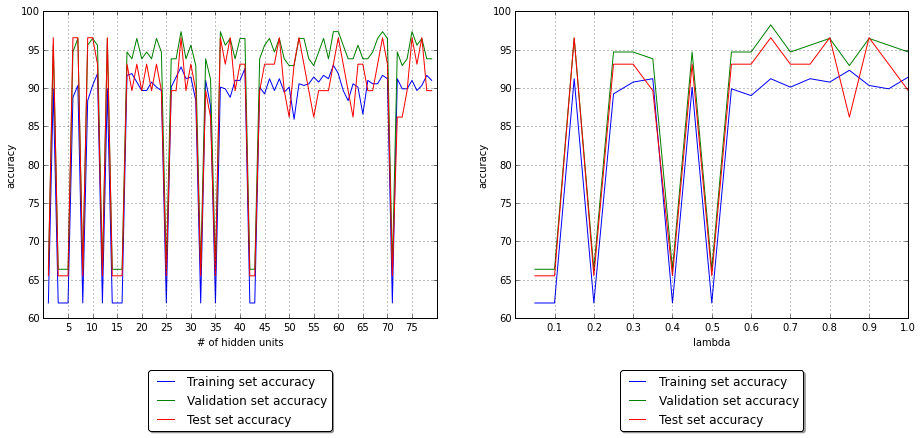

In [81]:
# Dataset 1
print "------------ Dataset 1 ------------"
train_data, train_label, validation_data,validation_label, test_data, test_label = get_data(file1)
df, predicted_test_label = run_main_code(train_data, train_label, validation_data,validation_label, test_data, test_label)
plot_dataframe_results(df)
# print '\n', df

In [76]:
print predicted_test_label
x = test_label.argmax(axis=1)
print x

[0 1 0 1 1 1 0 1 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1
 1 0 1 0 1 1 0 1 0 0 1 1 0 1 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 1 1 1 0 0
 0 0 0 0 1 1 1 0 0 0 1]
[0 0 0 1 1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1
 1 0 1 0 1 1 0 1 0 0 1 1 0 1 0 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0
 0 0 0 0 1 1 0 0 0 0 0]


------------ Dataset 2 ------------
Total execution time: 0.175481001536

Optimum # of hidden units = 53
Optimum lambda value = 0.05
Accuracy on the test dataset = 75.00%


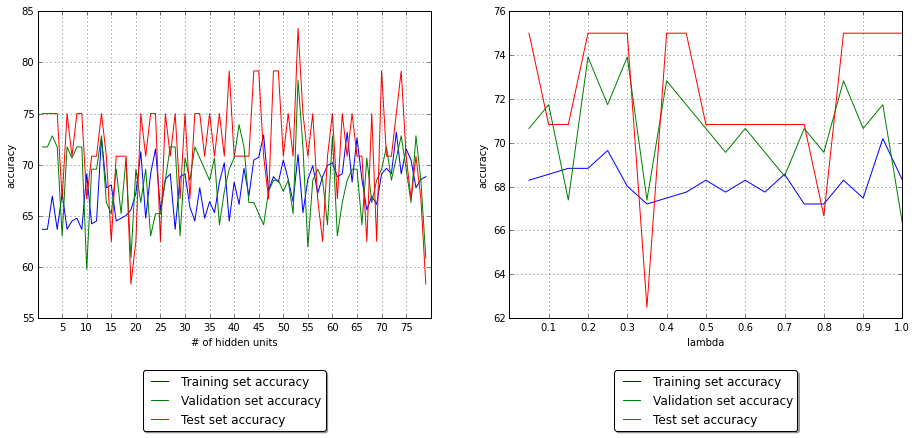

In [84]:
# Dataset 2
print "------------ Dataset 2 ------------"
train_data, train_label, validation_data,validation_label, test_data, test_label = get_data(file2)
df, predicted_test_label = run_main_code(train_data, train_label, validation_data,validation_label, test_data, test_label)
plot_dataframe_results(df)
# print '\n', df

# 3rd dataset
### 7005 features and only 35 training examples

------------ Dataset 3 ------------

Features reduced from 7004 to 2 with PCA
Total execution time: 0.0394798994064

Optimum # of hidden units = 5
Optimum lambda value = 0.15
Accuracy on the validation dataset = 85.71%

Predicted labels for test data:
[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]


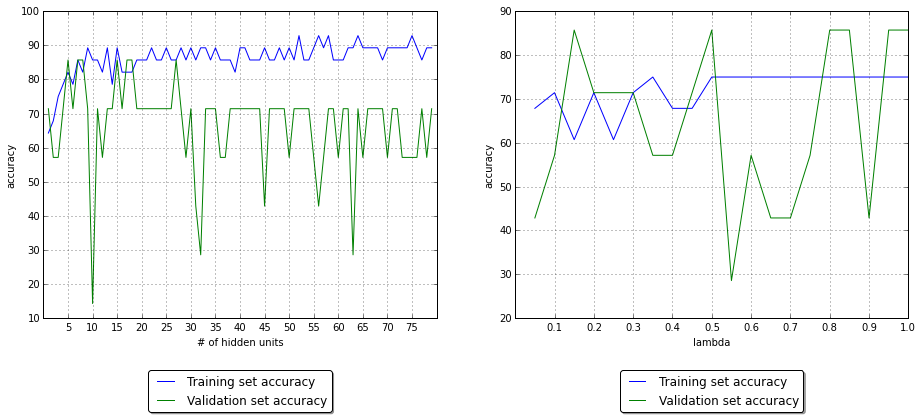

In [131]:
# Dataset 3
print "------------ Dataset 3 ------------"

# Division of dataset
training_data_percentage = 80
validation_data_percentage = 20

# Read datasets
train_df = pd.read_csv(train_data_file3, delimiter=" ", header=None).transpose()
train_label_df = pd.read_csv(train_label_file3, delimiter=" ", header=None)
test_df = pd.read_csv(test_data_file3, delimiter=" ", header=None).transpose()

# Calculate sizes of partitions
size_of_dataset = train_df.shape[0]
train_size = int(training_data_percentage * size_of_dataset / 100.0)
validation_size = int(validation_data_percentage * size_of_dataset / 100.0)

# Make partitions
train_data3 = train_df[:train_size].as_matrix()
validation_data3 = train_df[train_size:train_size+validation_size].as_matrix()
test_data3 = test_df.as_matrix()
# print '\n',train_data.shape
# print validation_data.shape
# print test_data.shape

# Make label data
training_labels3 = get_labels(train_label_df[:train_size].as_matrix())
validation_labels3 = get_labels(train_label_df[train_size:train_size+validation_size].as_matrix())

# Perform feature-selection with PCA
# train_data, validation_data, test_data = doFeatureSelection(train_data, validation_data, test_data)
train_data3 = applyPCA(train_data3)
validation_data3 = applyPCA(validation_data3)
test_data3 = applyPCA(test_data3)

print '\nFeatures reduced from', train_df.shape[1], 'to' ,train_data3.shape[1], "with PCA"

df, predicted_test_label = run_main_code(train_data3, training_labels3, validation_data3, validation_labels3, test_data3, None)
plot_dataframe_results(df, has_test_labels=False)

print "\nPredicted labels for test data:\n", predicted_test_label